## 网络中的网络 （NiN）
`NiN`提供了解决使用全连接层会放弃表征的空间结构的问题：在每个像素的通道上分别使用多层感知机。

## NiN块
卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。另外，全连接层的输入和输出通常是分别对应样本和特征的二维张量。NiN的想法是在每个像素的位置（针对每个高度和宽度）应用一个全连接层。如果我们将权重连接到每个空间的位置。将其视为 $1 \times 1$ 卷积层，或者作为在每个像素位置上的独立作用的全连接层。从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）

下图说明了VGG和NiN及它们块之间的主要架构差异。NiN以一个普通卷积层开始，后面是两个 $1 \times 1$ 的卷积层。这两个 $1 \times 1$ 卷积层充当带有ReLU激活函数的逐像素全连接层。第一层的卷积窗口形状通常由用户设置。随后卷积窗口的形状固定为  $1 \times 1$ 。

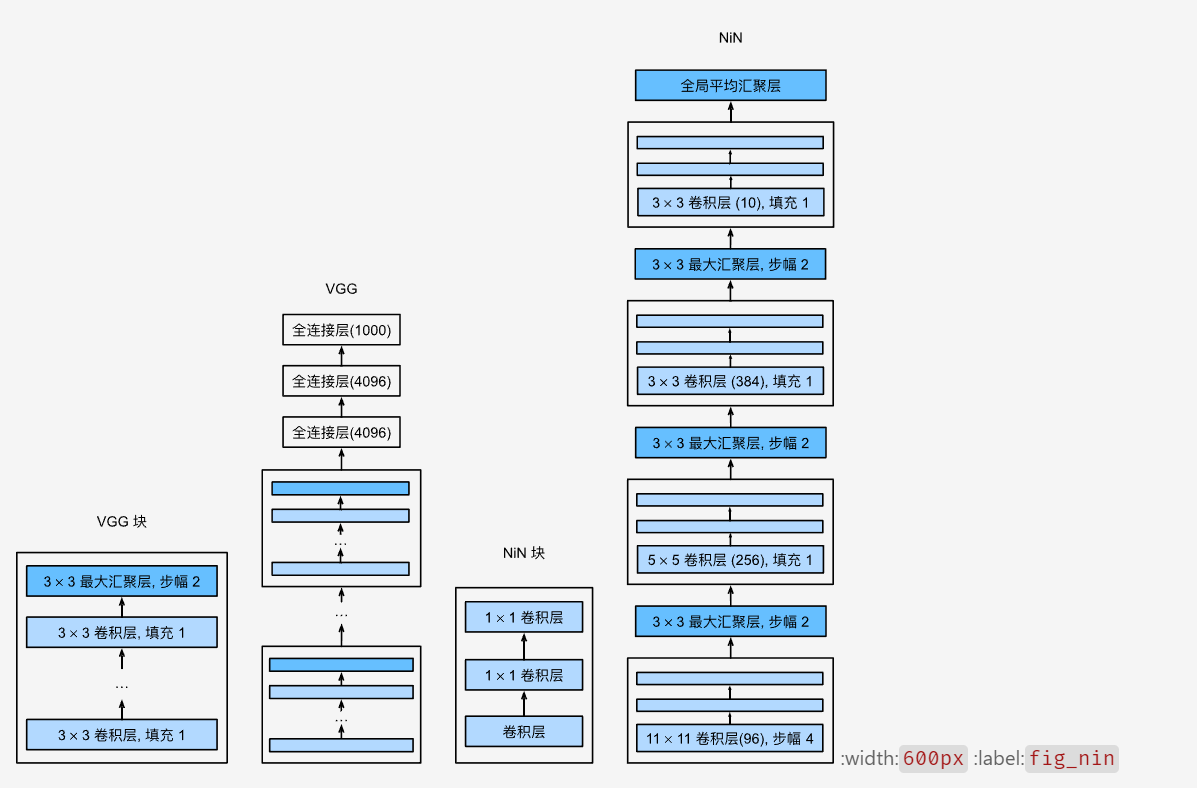

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

## NiN模型
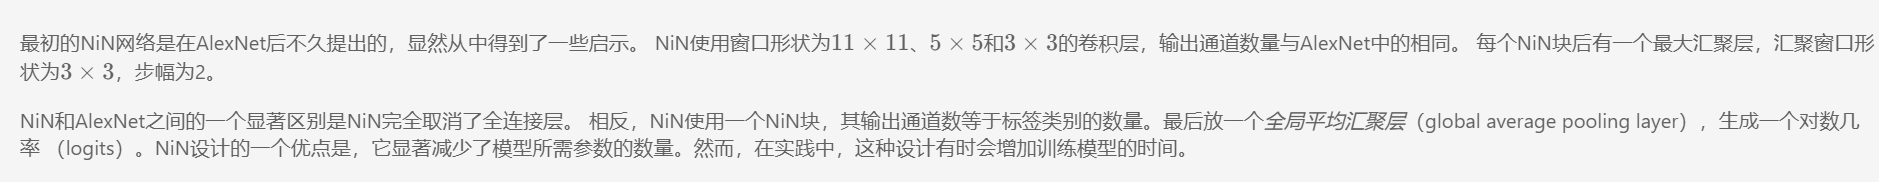

In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten()
)

创建一个数据样本来查看每个块的输出形状

In [3]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


使用Fashion-MNIST来训练模型

loss 0.888, train acc 0.656, test acc 0.676
2037.2 examples/sec on cuda:0


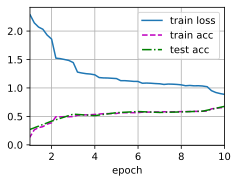

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

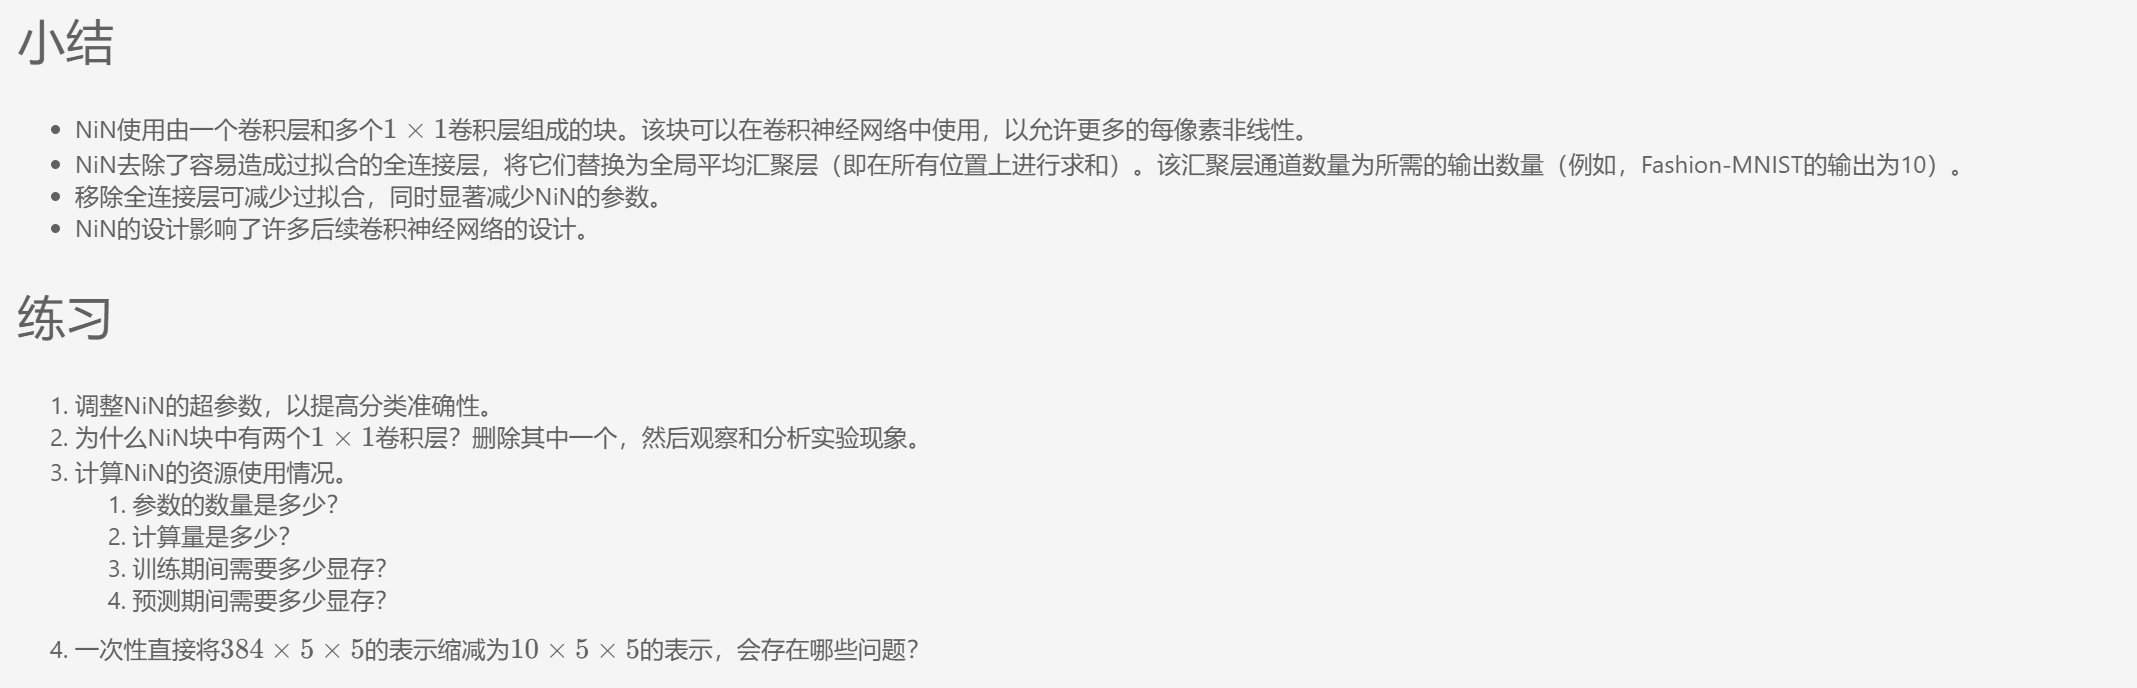